In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)


hide_toggle()

In [2]:
#zwykła konwolucyjna sieć - obrazek czas x czestosc, kanały RGB - elektrody - przetestować
#CONV2D, minpooling potem, dense (f-cja aktywacji softmax) - wyjscie to p-stwo wyjscia z klas
#punkt początkowy j.w.
#filtr dla sieci - dłuższy w czasie (np. 7,11), najwyżej dociać
#zbiory uczące - potem będziemy składać sieci
#zbiory - 2 sposoby jak je budować (od Mateusza)
#widmo - spr do jakiej częstości obciąć (z tego co wychodzi z abs hilberta), 6 razy mniej (?)
#kilka próbek od kilku pacjentów

#wyćwiczone na wszystkich - wyzerować któreś i tak sprawdzić (pasmo częstowściowe)
hide_toggle()

In [3]:
''' 25 na 5 foldów - 5x5 średnie acc, auc
    8 walidacyjnych zostaje
    5 różnych modeli - dla każddego z osobna walidacja
    jesli więcej niż 3 modele na daną klase - zaklasyfikowany - policzyć accuracy,
    wykresy acc w czasie i loss w czasie dla każdej z 5 (25 na 5 foldów) modeli (w każdej iteracji),
    sprawadź dla paru batch size jak sie zachowują wykresy,
    '''
hide_toggle()

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, Dropout
from typing import Iterable, Union

from tensorflow.keras.utils import to_categorical
from get_data import get_training, get_test
from learning import fit, evaluate, plot_history

from numpy.random import seed
seed(9849)
from tensorflow import set_random_seed
set_random_seed(6432)

hide_toggle()

In [39]:
def create_model(sample_shape: Iterable,
                 no_classes: int, kernel1:Iterable, kernel2:Iterable,
                 optimizer = 'adam', loss_fun = 'binary_crossentropy'):
    model = Sequential()
    model.add(Conv2D(24, kernel_size = kernel1,input_shape=sample_shape, activation='relu', data_format = 'channels_last'))
    model.add(AveragePooling2D(kernel2))
    model.add(Dropout(0.3))
    model.add(Dense(26, activation='relu')) #kolejne relu
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(no_classes, activation='softmax'))
    model.compile(loss=loss_fun, optimizer=optimizer, metrics=['accuracy'])
    return model

In [40]:
# Różne kernele - (7,1), (11,1) itp - średnia ważona/szuka kształtu na przsezbiegu obwieddni -> uśrednia - czy jakaś 
#struktura występuje


# Loading data

In [4]:
dire = "./npy_data/"
dire = "./npy_data2/"
# dire=""
class_no8 = np.load(dire+'class_no8.npy')
data_no8 = np.load(dire+'data_no8.npy')


class_no13 = np.load(dire+'class_no13.npy')
data_no13 = np.load(dire+'data_no13.npy')

class_no18 = np.load(dire+'class_no18.npy')
data_no18 = np.load(dire+'data_no18.npy')

class_no23 = np.load(dire+'class_no23.npy')
data_no23 = np.load(dire+'data_no23.npy')

class_no28 = np.load(dire+'class_no28.npy')
data_no28 = np.load(dire+'data_no28.npy')

class_no33 = np.load(dire+'class_no33.npy')
data_no33 = np.load(dire+'data_no33.npy')

hide_toggle()

## Picture options - time x freq bands or time x channels

In [5]:
freq_bands = 'ijkl->jlik'
channels = 'ijkl->jlki'
option = freq_bands

### Validation dataset

In [6]:
X_validation = np.einsum(option,data_no8)
y_validation = to_categorical(class_no8).astype(int)

## Prepared combinations

In [7]:
X = {1 : data_no13, 2: data_no18, 3: data_no23, 4: data_no28, 5: data_no33}
y = {1 : class_no13, 2: class_no18, 3: class_no23, 4: class_no28, 5: class_no33}
combinations_train = ((1,2,3,4),
                      (1,2,3,5),
                      (1,2,4,5),
                      (1,3,4,5),
                      (2,3,4,5))

combinations_test = (5, 4, 3, 2, 1)

### Params

In [41]:
batch_size = 200
no_epochs = 25
verbosity = 1
loss_fun = 'binary_crossentropy'

## Datasets

In [46]:
combination = 4
X_train, y_train = get_training(X, y, combinations_train[combination], option)
X_test, y_test = get_test(X, y, combinations_test[combination], option)
sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [47]:
X_validation.shape[0] + X_test.shape[0] + X_train.shape[0]

29911

## Learning

In [48]:
sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
"Creating model"
model = create_model(sample_shape, 2, (7,1), (11,1), optimizer='adam')

"Fitting model to data"
fitted_model, hist = fit(model, X_train, y_train, X_test, y_test, 
            batch_size, no_epochs)

Train on 18044 samples, validate on 4550 samples
Epoch 1/25
18044/18044 [==============================] - 2s 118us/sample - loss: 0.7126 - acc: 0.5067 - val_loss: 0.6893 - val_acc: 0.5352
Epoch 2/25
18044/18044 [==============================] - 2s 96us/sample - loss: 0.6930 - acc: 0.5283 - val_loss: 0.6873 - val_acc: 0.5437
Epoch 3/25
18044/18044 [==============================] - 2s 96us/sample - loss: 0.6905 - acc: 0.5381 - val_loss: 0.6922 - val_acc: 0.5180
Epoch 4/25
18044/18044 [==============================] - 2s 95us/sample - loss: 0.6876 - acc: 0.5397 - val_loss: 0.6879 - val_acc: 0.5411
Epoch 5/25
18044/18044 [==============================] - 2s 96us/sample - loss: 0.6845 - acc: 0.5556 - val_loss: 0.6858 - val_acc: 0.5455
Epoch 6/25
18044/18044 [==============================] - 2s 96us/sample - loss: 0.6841 - acc: 0.5512 - val_loss: 0.6857 - val_acc: 0.5521
Epoch 7/25
18044/18044 [==============================] - 2s 95us/sample - loss: 0.6806 - acc: 0.5647 - val_loss: 0.

## Evaluating

Test loss: 0.6782204704449544 / Test accuracy: 0.5783790946006775


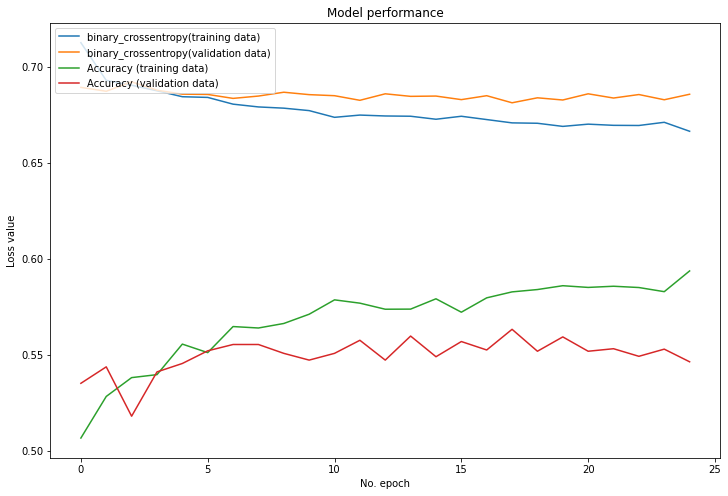

In [49]:
"Getting validation and loss score"
score = evaluate(fitted_model, X_validation, y_validation)

"Plotting history"
plot_history(hist, loss_fun)

## Collecting votes

In [13]:
X_validation = np.einsum(option,data_no8)
y_validation = to_categorical(class_no8).astype(int)

In [14]:
part = np.load(dire+'participants.npy')
print(part[:8])
print(part[8:13])
print(part[13:18])
print(part[18:23])
print(part[23:28])
print(part[28:33])
print(combinations_train[2])

['m17' 'k10' 'm16' 'k11' 'm6' 'k14' 'm10' 'k7']
['m11' 'm5' 'm7' 'm1' 'm18']
['k5' 'm15' 'k18' 'k3' 'm14']
['m13' 'm2' 'k16' 'k6' 'm9']
['k4' 'm8' 'm12' 'm3' 'k15']
['k12' 'k13' 'k8' 'k9' 'm4']
(1, 2, 4, 5)


In [15]:
batch_size = 200
no_epochs = 10

trials = y_validation.shape[0]
pred = np.zeros((5,trials))

for i in range(5):
    X_train, y_train = get_training(X, y, combinations_train[i], option)
    X_test, y_test = get_test(X, y, combinations_test[i], option)
    sample_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    
    model = create_model(sample_shape, 2, (7,1))
    
    fitted_model, _ = fit(model, X_train, y_train, X_test, y_test, 
                batch_size, no_epochs, verbosity = 1)
    "Getting validation and loss score"
    score = evaluate(fitted_model, X_validation, y_validation)
    pred[i] = fitted_model.predict_classes(X_validation)
    print(i)
votes = np.sum(pred, axis = 0)
votes[votes<=2] = 0
votes[votes>=3] = 1
score = len(votes[class_no8==votes])
acc = score/trials
print(acc)

Train on 17869 samples, validate on 4725 samples
Epoch 1/10
17869/17869 [==============================] - 2s 93us/sample - loss: 0.7075 - acc: 0.5119 - val_loss: 0.6893 - val_acc: 0.5342
Epoch 2/10
17869/17869 [==============================] - 2s 87us/sample - loss: 0.6933 - acc: 0.5284 - val_loss: 0.6870 - val_acc: 0.5454
Epoch 3/10
17869/17869 [==============================] - 2s 84us/sample - loss: 0.6886 - acc: 0.5372 - val_loss: 0.6859 - val_acc: 0.5566
Epoch 4/10
17869/17869 [==============================] - 2s 84us/sample - loss: 0.6861 - acc: 0.5452 - val_loss: 0.6859 - val_acc: 0.5520
Epoch 5/10
17869/17869 [==============================] - 2s 84us/sample - loss: 0.6840 - acc: 0.5539 - val_loss: 0.6848 - val_acc: 0.5606
Epoch 6/10
17869/17869 [==============================] - 2s 85us/sample - loss: 0.6843 - acc: 0.5532 - val_loss: 0.6844 - val_acc: 0.5642
Epoch 7/10
17869/17869 [==============================] - 2s 86us/sample - loss: 0.6825 - acc: 0.5564 - val_loss: 0.6